In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
import pointpats
import seaborn as sns
%matplotlib inline

In [2]:
def export_tif(ds, crs, path):

    import rasterio
    import rioxarray
    ds.rio.set_crs(crs, inplace=True)
    ds.rio.to_raster(path, driver='GTiff')
    
    x = ds['lon'].data
    y = ds['lat'].data
    src = rasterio.open(path)
    # get meta dict
    meta = src.meta

    # calculate pixel size
    pixel_size = np.diff(x).min()

    # add new affine
    meta['transform'] = rasterio.Affine(float(pixel_size), float(0.0), x.min(),
                    0.0, float(-pixel_size), float(y.max()))

    # export to tiff
    with rasterio.open(path, 'w', **meta) as raster:
        # If array is in  (y, x, z) order (cols, rows, bands)
        source = np.flip(src.read(), axis=1)
        raster.write(source)

### Set directory

In [3]:
os.chdir("/home/silva/Research/Alta Floresta/")

In [4]:
dset = xarray.open_dataset('DATASETS/dset_AF_4.nc')
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 ...
    lat                    (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables: (12/20)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    pos_locations_buffer   (y, x) float64 ...
    litho_classes          (y, x) float32 ...
    idade_min              (y, x) float32 ...
    idade_max              (y, x) float32 ...
    Th_K                   (y, x) float64 ...
    U_K                    (y, x) float64 ...
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

### Positive examples

In [5]:
# filter locations where lat > -10.25
train_idk, train_idj = np.where(dset['lat'].data > -10.15)
# filter locations where lat <= -10.25
test_idk, test_idj = np.where(dset['lat'].data <= -10.15)

In [6]:
ny0, nx0 = np.unique(dset['lat'].data[train_idk, train_idj]).size, np.unique(dset['lon'].data[train_idk, train_idj]).size
print((ny0, nx0))
ny1, nx1 = np.unique(dset['lat'].data[test_idk, test_idj]).size, np.unique(dset['lon'].data[test_idk, test_idj]).size
print((ny1, nx1))

(581, 1322)
(754, 1322)


In [7]:
lon = dset['lon'].data[test_idk, test_idj].reshape(ny1, nx1)
lat = dset['lat'].data[test_idk, test_idj].reshape(ny1, nx1)

In [8]:
cond1 = (dset['labels'].data[test_idk, test_idj].reshape(ny1, nx1) == 1) 
cond2 = (dset['labels'].data[test_idk, test_idj].reshape(ny1, nx1) == 2)

# positive locations' index
occ_k, occ_j = np.where(cond1)
dep_k, dep_j = np.where(cond2)

In [15]:
# import predictions' probabilities    
import pickle
filename = "PICKLE/final_probs_fav_lithos.pickle"
with open(filename, 'rb') as f:
    probs = pickle.load(f)

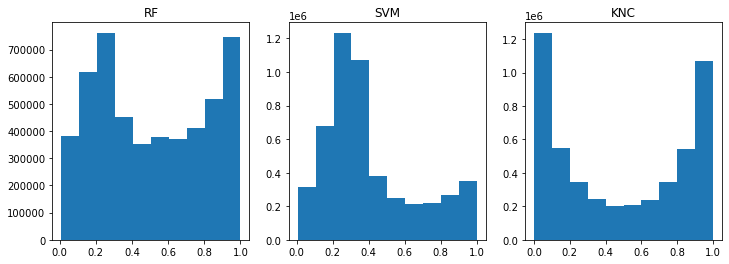

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].hist(probs['rf'].ravel())
ax[1].hist(probs['svm'].ravel())
ax[2].hist(probs['knc'].ravel())
ax[0].set_title('RF'); ax[1].set_title('SVM'); ax[2].set_title('KNC')
plt.show()

In [17]:
def remove_extreme(grid):
    grid = np.where(grid == 1.0, 0.9999, grid)
    grid = np.where(grid == 0.0, 0.0001, grid)
    
    return grid

In [28]:
probs['knc'] = remove_extreme(probs['knc'])

In [29]:
def calc_risk_return(grid, lon=lon, lat=lat, remove_nan=True, ny=ny1, nx=nx1, method='nearest', original=False):
    from scipy.interpolate import griddata
    
    if original == False:
    
        lon = lon.ravel()
        lat = lat.ravel()

        L = grid.shape[0]
        np.seterr(divide='ignore', invalid='ignore')
        replace = np.nanmean(grid)
        grid = np.nan_to_num(grid, nan=replace)
        odds = grid/(1-grid)
        log_O = np.log2(odds) # log odds ratios
        log_mean = np.mean(log_O, axis=0)
        log_std = np.std(log_O, axis=0)
        return_grid = (1/L)*log_mean
        risk_grid = (1/(L-1))*log_std
        # ravel it
        return_grid = return_grid.ravel()
        risk_grid = risk_grid.ravel()

        if remove_nan:
            # remove nan & inf
            f1 = (np.isnan(return_grid) == False)
            f2 = (return_grid != np.inf)
            f3 = (return_grid != -np.inf)
            t1 = (np.isnan(return_grid.ravel()) == True)
            t2 = (return_grid == np.inf)
            t3 = (return_grid == -np.inf)

            cond1 = np.where(f1 & f2 & f3)[0]
            cond2 = np.where(t1 | t2 | t3)[0]

            return_grid[cond2] = griddata((lon[cond1], lat[cond1]),
                            return_grid[cond1], (lon[cond2], lat[cond2]), method=method)


            # remove nan & inf
            f1 = (np.isnan(risk_grid) == False)
            f2 = (risk_grid != np.inf)
            f3 = (risk_grid != -np.inf)
            t1 = (np.isnan(risk_grid.ravel()) == True)
            t2 = (risk_grid == np.inf)
            t3 = (risk_grid == -np.inf)

            cond1 = np.where(f1 & f2 & f3)[0]
            cond2 = np.where(t1 | t2 | t3)[0]

            risk_grid[cond2] = griddata((lon[cond1], lat[cond1]),
                            risk_grid[cond1], (lon[cond2], lat[cond2]), method=method)

    if original:
        return_grid = np.mean(grid, axis=0)
        risk_grid = np.std(grid, axis=0)
    
    return return_grid.reshape(ny, nx), risk_grid.reshape(ny, nx)

In [30]:
dict_return = {}
dict_risk = {}
# occ return
min_occ_return = {}
max_occ_return = {}
# occ risk
min_occ_risk = {}
max_occ_risk = {}
# dep return
min_dep_return = {}
max_dep_return = {}
# dep risk
min_dep_risk = {}
max_dep_risk = {}
# avg
avg_risk = {}
avg_return = {}


mnames = 'rf svm knc'.split(' ')

for m in tqdm(mnames):
    dict_return[m], dict_risk[m] = calc_risk_return(probs[m], method='nearest')
    # min return/ max return
    min_dep_return[m] = np.nanmin(dict_return[m][dep_k, dep_k])
    max_dep_return[m] = np.nanmax(dict_return[m][dep_k, dep_k])
    min_dep_risk[m] = np.nanmin(dict_risk[m][dep_k, dep_j])
    max_dep_risk[m] = np.nanmax(dict_risk[m][dep_k, dep_j]) 
    # occ
    min_occ_return[m] = np.nanmin(dict_return[m][occ_k, occ_j])
    max_occ_return[m] = np.nanmax(dict_return[m][occ_k, occ_j]) 
    min_occ_risk[m] = np.nanmin(dict_risk[m][occ_k, occ_j]) 
    max_occ_risk[m] = np.nanmax(dict_risk[m][occ_k, occ_j]) 
    
    # avg
    avg_risk[m] = np.nanmean(dict_risk[m][dep_k, dep_j])
    avg_return[m] = np.nanmean(dict_return[m][dep_k, dep_j])

  0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
for m in tqdm(mnames):
    print(f'{m}: min-dep-risk: {min_dep_risk[m]:.6f} | max-dep-risk: {max_dep_risk[m]:.6f} | min-occ-return: {min_dep_return[m]:.6f}')

  0%|          | 0/3 [00:00<?, ?it/s]

rf: min-dep-risk: 0.119496 | max-dep-risk: 0.484634 | min-occ-return: -0.250664
svm: min-dep-risk: 0.094849 | max-dep-risk: 0.340301 | min-occ-return: -0.519631
knc: min-dep-risk: 1.029419 | max-dep-risk: 1.272196 | min-occ-return: -0.229984


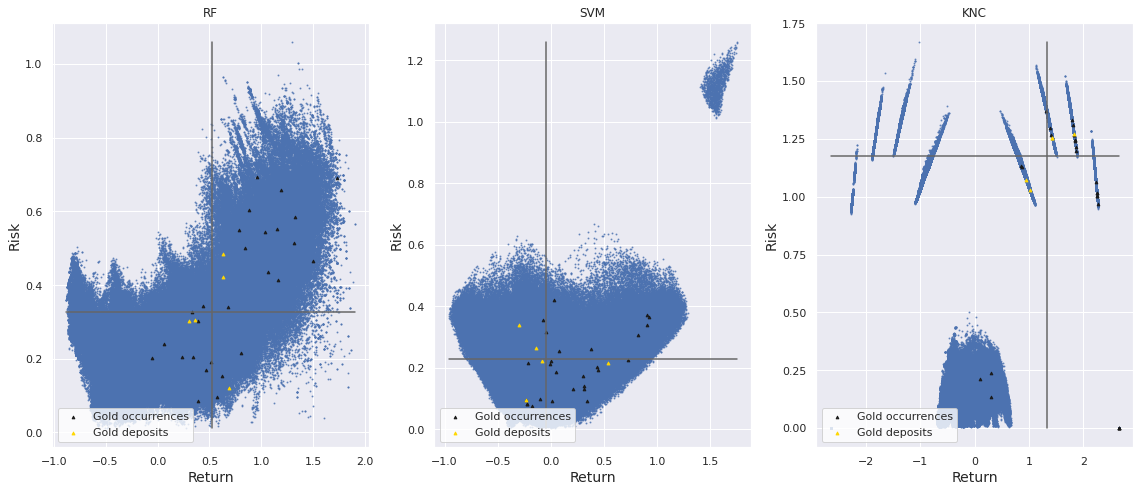

In [32]:
sns.set_theme()
fig, ax = plt.subplots(1, 3, figsize=(16, 7), facecolor='w')
ax = ax.flatten()
for i, m in enumerate(mnames):
    ax[i].scatter(dict_return[m].ravel(), dict_risk[m].ravel(), s=1, alpha=0.7)
    ax[i].scatter(dict_return[m][occ_k, occ_j].ravel(), dict_risk[m][occ_k, occ_j].ravel(), color='k', s=7, 
                label='Gold occurrences', marker='^')
    ax[i].scatter(dict_return[m][dep_k, dep_j].ravel(), dict_risk[m][dep_k, dep_j].ravel(), color='gold', s=8, 
                label='Gold deposits', marker='^')
    ax[i].plot([np.nanmin(dict_return[m]), np.nanmax(dict_return[m])], [avg_risk[m], avg_risk[m]], color='.4')
    ax[i].plot([avg_return[m], avg_return[m]], [np.nanmin(dict_risk[m]), np.nanmax(dict_risk[m])], color='.4')
    ax[i].set_xlabel('Return', fontsize=14)
    ax[i].set_ylabel('Risk', fontsize=14)
    ax[i].legend(facecolor='w', loc='lower left')
    ax[i].set_title(m.upper())
    
plt.tight_layout()
plt.savefig(f'figs/risk_return_sectors.png', dpi=400, bbox_inches='tight')
plt.show()

In [33]:
def create_sectors(dict_risk, dict_return, avg_risk, avg_return, ny1=ny1, nx1=nx1):
    # low-risk vs high-return
    LRHR = np.where((dict_risk <= avg_risk) & (dict_return >= avg_return))

    # high-risk vs high-return
    HRHR = np.where((dict_risk > avg_risk) & (dict_return >= avg_return))

    # low-risk vs low-return
    LRLR = np.where((dict_risk <= avg_risk) & (dict_return < avg_return))

    # high-risk vs low-return
    HRLR = np.where((dict_risk > avg_risk) & (dict_return < avg_return))
        
    grid = np.ones((ny1, nx1))
    grid[LRHR] = 4
    grid[HRHR] = 3
    grid[LRLR] = 2
    grid[HRLR] = 1

    return grid

In [34]:
grid = {}
for m in tqdm(mnames):
    grid[m] = create_sectors(dict_risk[m], dict_return[m], avg_risk[m], avg_return[m])

  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
for m in tqdm(mnames):
    unique, counts = np.unique(grid[m], return_counts=True)
    print(m)
    c = np.around(counts *100/np.sum(counts), 4)
    print(f'{c}')

  0%|          | 0/3 [00:00<?, ?it/s]

rf
[ 5.9234 75.3578 13.474   5.2447]
svm
[16.3509 56.0448 15.3839 12.2204]
knc
[ 9.8462 66.4713 14.9489  8.7336]


In [36]:
import matplotlib
icolors = np.arange(0, 6, dtype=int)
relcolor =  matplotlib.cm.Set1
colors = np.array(relcolor.colors)[icolors][::-1]
cmap = matplotlib.colors.ListedColormap(colors)

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_200745/1891970167.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(lon, lat, grid[m], shading='auto', cmap=cmap)
/tmp/ipykernel_200745/1891970167.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, ax=ax, orientation='horizontal')


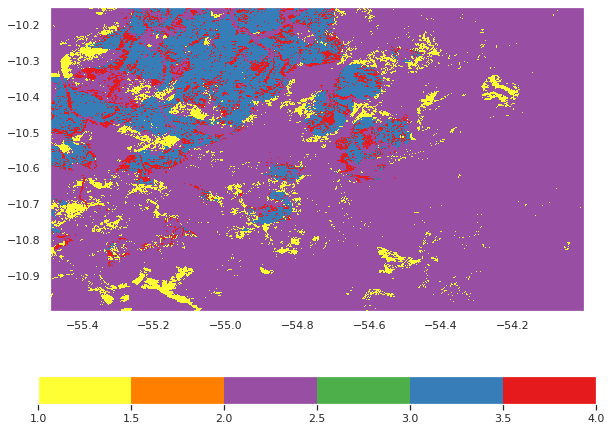

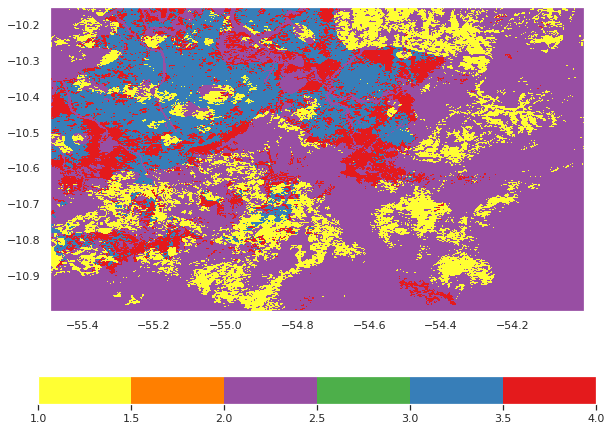

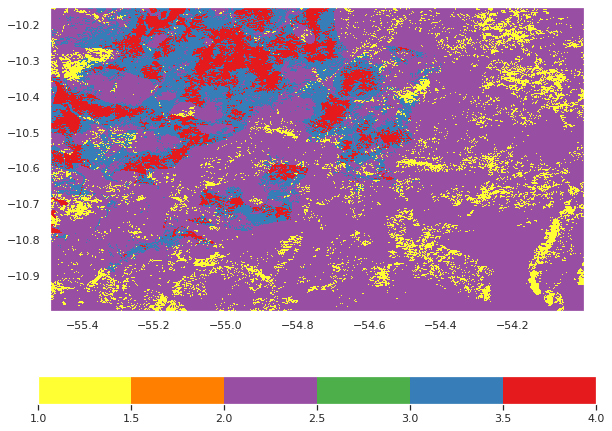

In [37]:
risk_return_labels = ['high risk-high return', 'high risk-high return',
                    'low risk-low return', 'high risk-low return']

for m in tqdm(mnames):
    idxs = np.arange(0, 4, 1)
    half = (idxs[1]-idxs[0])/4
    ticks = 0.25 + np.arange(half, idxs[-1], 2*half)*1.5

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.pcolormesh(lon, lat, grid[m], shading='auto', cmap=cmap)
    plt.colorbar(im, ax=ax, orientation='horizontal')
    ax.set_aspect(1)
    ax.grid(True)
    plt.show()

In [38]:
from shapely import geometry
# EPSG:4674
crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"

dep_gdf = pd.DataFrame({'lon':lon[dep_k, dep_j].ravel(), 'lat':lat[dep_k, dep_j].ravel()})
# create geodataframe
dep_gdf['geometry'] = gpd.points_from_xy(dep_gdf.lon, dep_gdf.lat)
dep_gdf = gpd.GeoDataFrame(dep_gdf, geometry='geometry', crs=crs)

occ_gdf = pd.DataFrame({'lon':lon[occ_k, occ_j].ravel(), 'lat':lat[occ_k, occ_j].ravel()})
# create geodataframe
occ_gdf['geometry'] = gpd.points_from_xy(occ_gdf.lon, occ_gdf.lat)
occ_gdf = gpd.GeoDataFrame(occ_gdf, geometry='geometry', crs=crs)

In [39]:
dep_gdf.to_file('VETORES/deposits.gpkg', 'GPKG')
occ_gdf.to_file('VETORES/occurrences.gpkg', 'GPKG')

/home/silva/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/silva/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [40]:
datasets = {}

crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"
for m in tqdm(mnames):
    
    # gamma variables
    vars_dict = {}
    vars_dict['risk_return'] = (['y', 'x'], grid[m], {'4': 'low risk-high-return',
                                                      '3': 'high risk-high-return', 
                                                      '2': 'low risk-low return',
                                                      '1': 'high risk-low return'})
   
    # coordinates
    coords = {}
    coords['lon'] = (["y", "x"], lon, {'crs': crs, 'EPSG':'4674'})
    coords['lat'] = (["y", "x"], lat, {'crs': crs, 'EPSG':'4674'})

    attrs = dict(description=f"Risk-return maps ({m}) from Alta Floresta, MT, Brazil.")
    datasets[m] = xarray.Dataset(vars_dict, coords, attrs)
    export_tif(datasets[m], "epsg:4674", f'RASTERS/risk_return_{m}.tif')

  0%|          | 0/3 [00:00<?, ?it/s]

/home/silva/anaconda3/lib/python3.9/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  s = writer(path, mode, driver=driver,


In [159]:
filename = "PICKLE/final_aucs.pickle"
with open(filename, 'rb') as f:
    aucs = pickle.load(f)

In [160]:
for m in tqdm(mnames):
    print(f'{m}: {np.mean(aucs[m]):.3f}')

  0%|          | 0/3 [00:00<?, ?it/s]

rf: 0.772
svm: 0.723
knc: 0.773


In [161]:
from scipy.stats import entropy
entrop = {}
for m in tqdm(mnames):
    entrop[m] = entropy(probs[m], axis=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_6968/3842737253.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(lon, lat, entrop[m], shading='auto', cmap='viridis', vmin=np.percentile(entrop[m], 25),
/tmp/ipykernel_6968/3842737253.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, ax=ax, orientation='horizontal', label='Entropy')


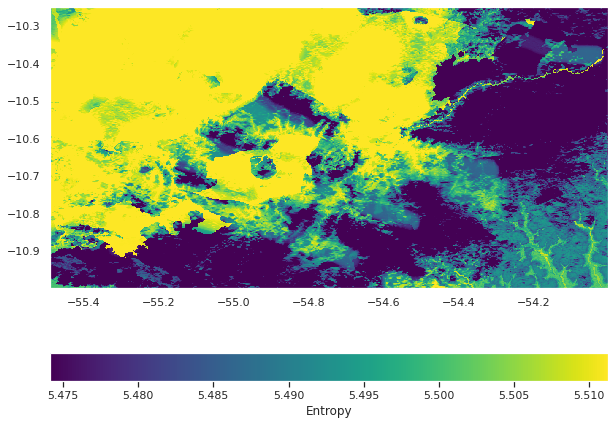

In [163]:
m = 'rf'
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.pcolormesh(lon, lat, entrop[m], shading='auto', cmap='viridis', vmin=np.percentile(entrop[m], 25),
                   vmax=np.percentile(entrop[m], 70))
plt.colorbar(im, ax=ax, orientation='horizontal', label='Entropy')
ax.set_aspect(1)
plt.show()

In [16]:
datasets = {}
mnames = 'rf svm knc'.split(' ')
crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"

for m in tqdm(mnames):
    prob_std = np.std(probs[m], axis=0)
    # gamma variables
    vars_dict = {}
    vars_dict['std'] = (['y', 'x'], prob_std, {'variable': f'std - {m}', 'unit': 'dimensionless'})

    # coordinates
    coords = {}
    coords['lon'] = (["y", "x"], lon, {'crs': crs, 'EPSG':'4674'})
    coords['lat'] = (["y", "x"], lat, {'crs': crs, 'EPSG':'4674'})

    attrs = dict(description=f"Prospectivity maps ({m}) from Alta Floresta, MT, Brazil.")
    datasets[m] = xarray.Dataset(vars_dict, coords, attrs)
    export_tif(datasets[m], "epsg:4674", f'RASTERS/std_{m}_fav_lithos.tif')

  0%|          | 0/3 [00:00<?, ?it/s]

/home/silva/anaconda3/lib/python3.9/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  s = writer(path, mode, driver=driver,
